In [1]:
import numpy as np
import pandas as pd

**Load Dataset**

In [2]:
df=pd.read_csv("Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.shape

(6362620, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


**Train-Test Split**

In [5]:
from sklearn.model_selection import train_test_split
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Split the data into 80% training and 20% testing
# stratify=y is essential for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (5090096, 10)
Testing set shape: (1272524, 10)


In [6]:
#The fraud distribution in the new sets should be the same proportion
print("\nFraud cases in original set: ", y.mean())
print("Fraud cases in training set: ", y_train.mean())
print("Fraud cases in testing set: ", y_test.mean())


Fraud cases in original set:  0.001290820448180152
Fraud cases in training set:  0.0012907418642005967
Fraud cases in testing set:  0.0012911347840983745


**EDA and data preprocessing**

In [7]:
X_train.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
dtype: int64

In [8]:
#Number of zeros in each column
zeros_per_column = (X_train == 0).sum()
print(zeros_per_column)

step                    0
type                    0
amount                 13
nameOrig                0
oldbalanceOrg     1681912
newbalanceOrig    2887757
nameDest                0
oldbalanceDest    2163068
newbalanceDest    1951534
isFlaggedFraud    5090080
dtype: int64


In [9]:
# Check the 'isFraud' status for transactions with an amount of 0
zero_amount = (X_train['amount'] == 0)
print(y_train[zero_amount].value_counts())

isFraud
1    13
Name: count, dtype: int64


All 13 values are crucial as they led our algorithm to learn how to find fraud transaction.

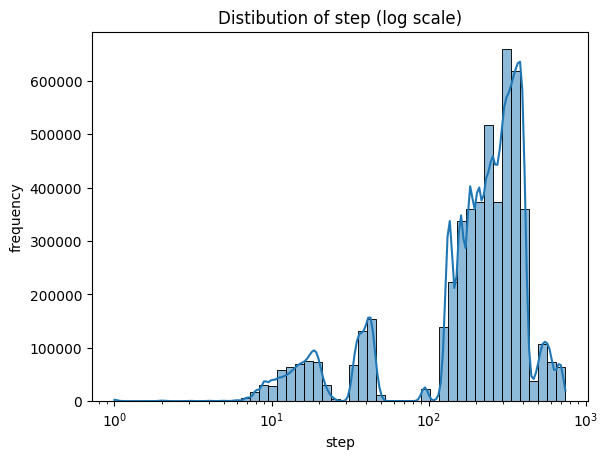

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


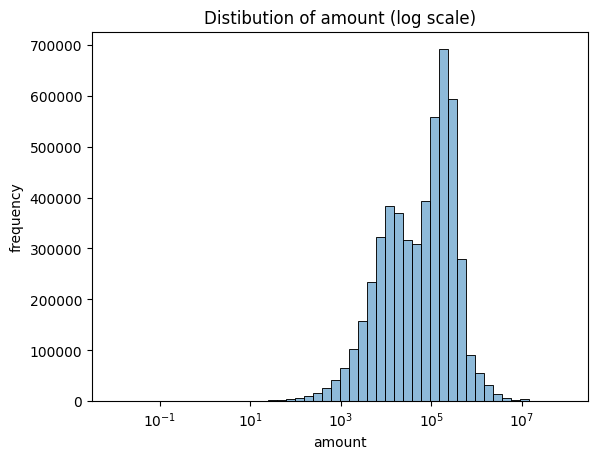

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


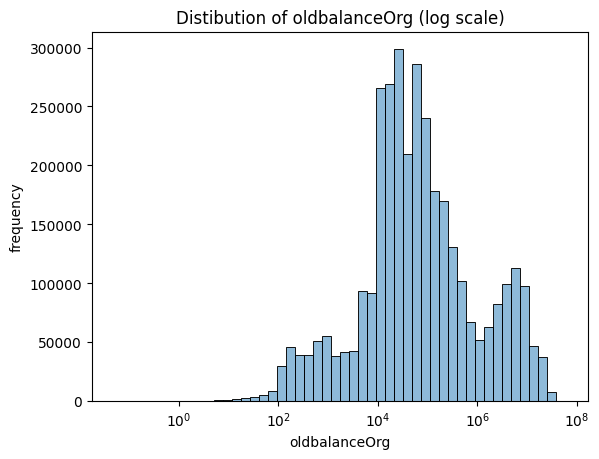

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


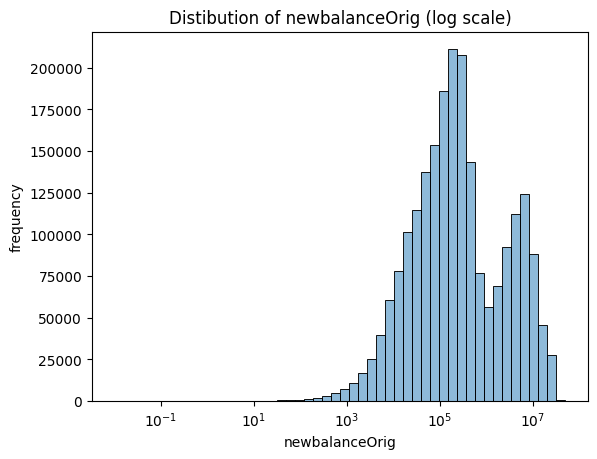

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


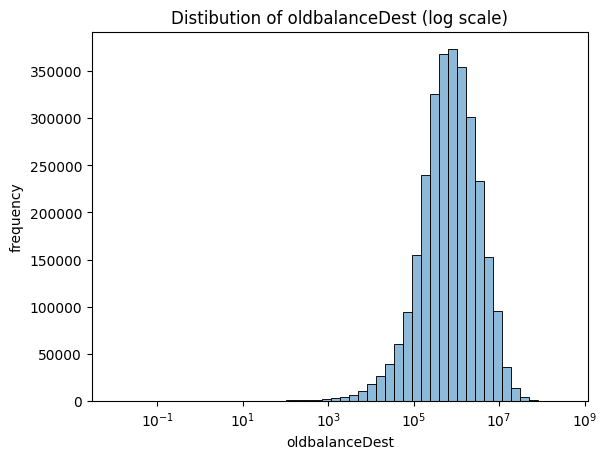

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


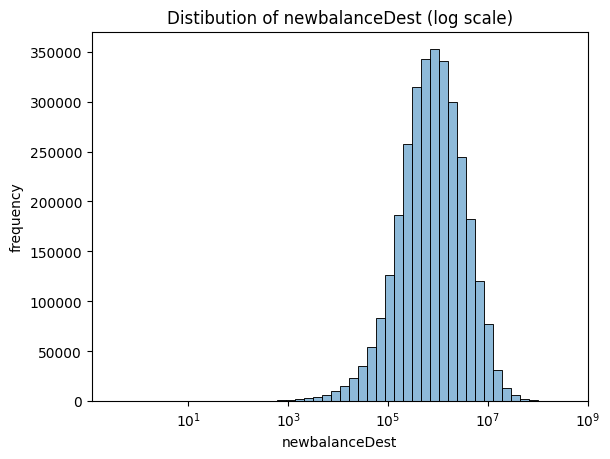

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
num_cols=["step","amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]
for col in num_cols:
    sns.histplot(X_train[col],bins=50, log_scale=True, kde=True)
    plt.title(f"Distibution of {col} (log scale)")
    plt.xlabel(col)
    plt.ylabel("frequency")
    plt.show()

Most features shows log-normal distribution.(heavily skewed)

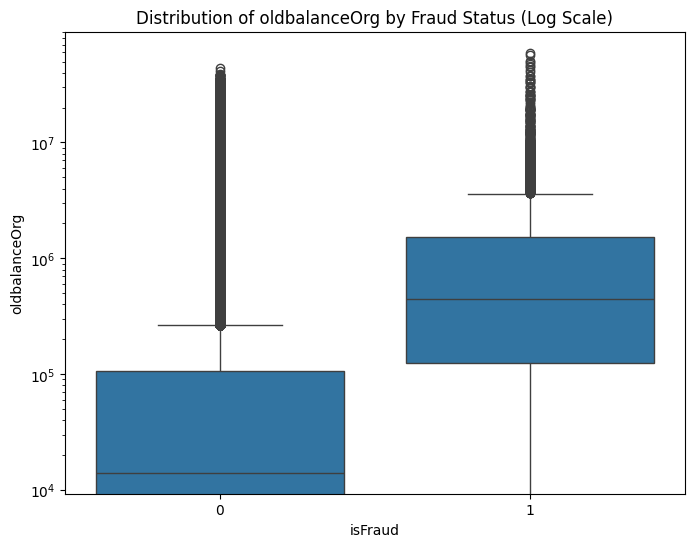

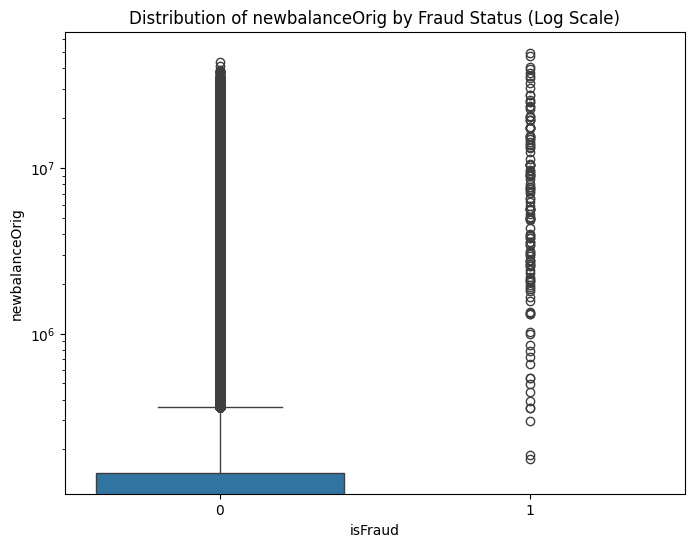

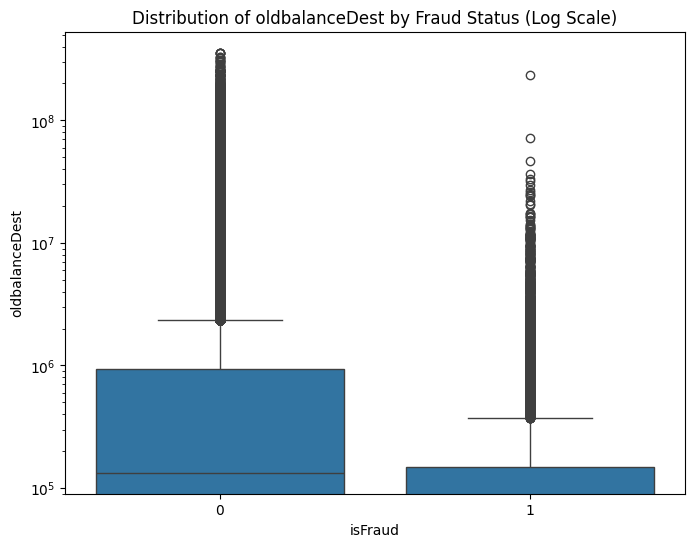

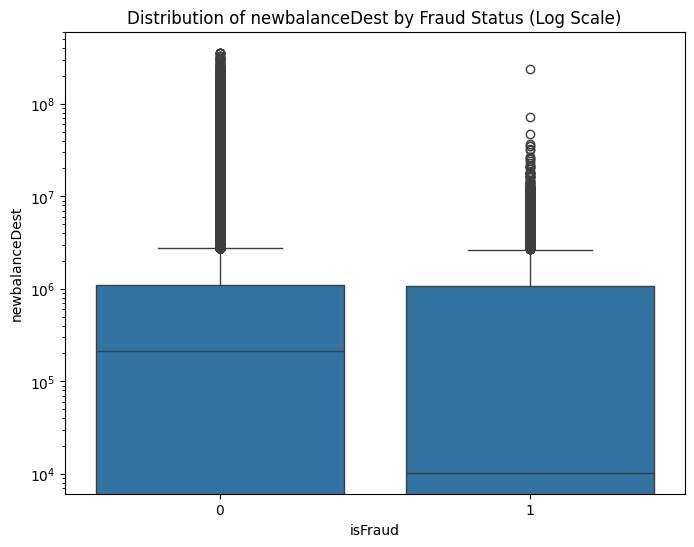

In [11]:
# We need to temporarily combine X_train and y_train for easy plotting
X_train_full = X_train.copy()
X_train_full['isFraud'] = y_train
acc_cols=["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]
for col in acc_cols:
    plt.figure(figsize=(8, 6))
    
    # Create the boxplot comparing the column across 'isFraud' categories
    sns.boxplot(x='isFraud', y=col, data=X_train_full)
    
    # Use a log scale for the y-axis, which is essential for the skewed financial columns
    plt.yscale('log')
    
    plt.title(f'Distribution of {col} by Fraud Status (Log Scale)')
    plt.show()

1)Box plot of oldbalanceOrg suggests that fraudsters specifically targeting accounts that have initially a high balance.

2)newbalanceOrig suggest that fraudsters want to completely drain the accounts that is; a transaction that results in a near-zero balance is highly suspicious.

3)Boxplot of oldbalanceDest has a median starting balance of 0; which suggest that fraudsters transfer money to newly created "mule" accounts that have no prior transaction history.

<Axes: ylabel='count'>

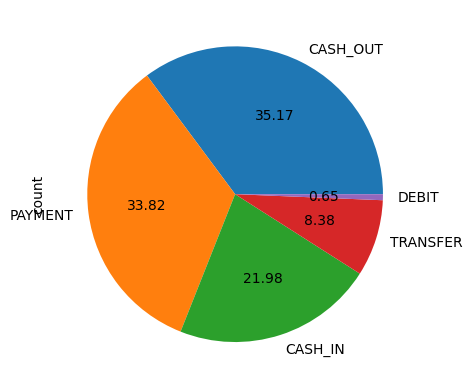

In [12]:
X_train["type"].value_counts().plot(kind='pie', autopct='%.2f')

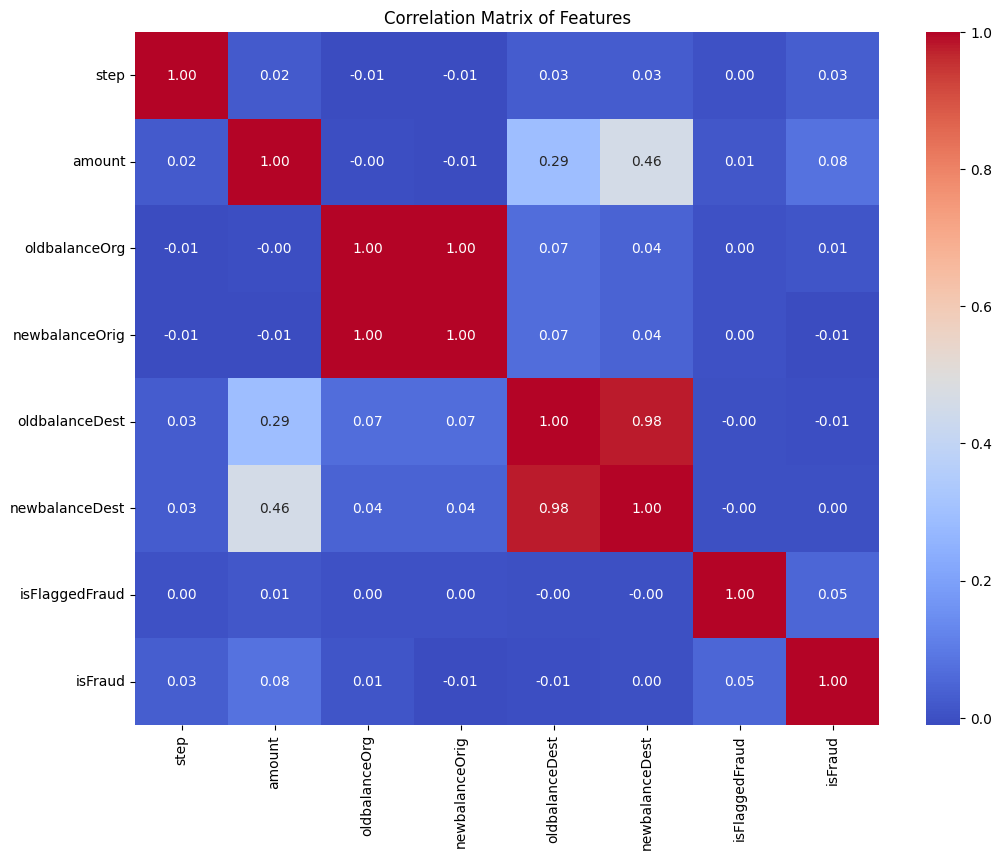

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train_temp = X_train.select_dtypes(include=['float64', 'int64']).copy()
X_train_temp["isFraud"]=y_train

corr_matrix = X_train_temp.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

**Feature Engineering**

In [14]:
#Flags for account types
X_train['is_dest_merchant'] = X_train['nameDest'].str.startswith('M').astype(int)
X_test['is_dest_merchant']=X_test['nameDest'].str.startswith('M').astype(int)

#Flags for zero balances
X_train['is_orig_balance_zero'] = (X_train['oldbalanceOrg'] == 0).astype(int)
X_train['is_new_balance_zero'] = (X_train['newbalanceOrig'] == 0).astype(int)
X_test['is_orig_balance_zero'] = (X_test['oldbalanceOrg'] == 0).astype(int)
X_test['is_new_balance_zero'] = (X_test['newbalanceOrig'] == 0).astype(int)

# Balance error features
X_train['error_balance_orig'] = X_train['oldbalanceOrg'] - X_train['amount'] - X_train['newbalanceOrig']
X_train['error_balance_dest'] = X_train['oldbalanceDest'] + X_train['amount'] - X_train['newbalanceDest']
X_test['error_balance_orig'] = X_test['oldbalanceOrg'] - X_test['amount'] - X_test['newbalanceOrig']
X_test['error_balance_dest'] = X_test['oldbalanceDest'] + X_test['amount'] - X_test['newbalanceDest']

Now nameOrig and nameDest features are of no use as we clearly separated merchants from rest of customers.

In [15]:
X_train = X_train.drop(['nameOrig', 'nameDest'], axis=1)
X_test = X_test.drop(['nameOrig', 'nameDest'], axis=1)

In [16]:
X_train.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,is_dest_merchant,is_orig_balance_zero,is_new_balance_zero,error_balance_orig,error_balance_dest
292779,15,PAYMENT,9914.74,44248.00,34333.26,0.00,0.00,0,1,0,0,0.00,9914.74
499763,20,PAYMENT,6854.53,0.00,0.00,0.00,0.00,0,1,1,1,-6854.53,6854.53
2970411,231,CASH_OUT,361211.80,0.00,0.00,489745.16,850956.95,0,0,1,1,-361211.80,0.01
3137549,236,PAYMENT,7083.51,0.00,0.00,0.00,0.00,0,1,1,1,-7083.51,7083.51
1500682,143,CASH_IN,218019.51,13045685.58,13263705.09,2438123.98,2220104.47,0,0,0,0,-436039.02,436039.02


In [17]:
X_train = pd.get_dummies(X_train, columns=['type'], prefix='type')
X_test = pd.get_dummies(X_test, columns=['type'], prefix='type')
print(X_train.head())

         step     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
292779     15    9914.74       44248.00        34333.26            0.00   
499763     20    6854.53           0.00            0.00            0.00   
2970411   231  361211.80           0.00            0.00       489745.16   
3137549   236    7083.51           0.00            0.00            0.00   
1500682   143  218019.51    13045685.58     13263705.09      2438123.98   

         newbalanceDest  isFlaggedFraud  is_dest_merchant  \
292779             0.00               0                 1   
499763             0.00               0                 1   
2970411       850956.95               0                 0   
3137549            0.00               0                 1   
1500682      2220104.47               0                 0   

         is_orig_balance_zero  is_new_balance_zero  error_balance_orig  \
292779                      0                    0                0.00   
499763                      1     

**Handling Class Imbalance (SMOTE)**

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Shape of original training data:", X_train.shape)
print("Shape of resampled training data:", X_train_resampled.shape)
print("\nValue counts of original y_train:\n", y_train.value_counts())
print("\nValue counts of resampled y_train:\n", y_train_resampled.value_counts())

Shape of original training data: (5090096, 17)
Shape of resampled training data: (10167052, 17)

Value counts of original y_train:
 isFraud
0    5083526
1       6570
Name: count, dtype: int64

Value counts of resampled y_train:
 isFraud
0    5083526
1    5083526
Name: count, dtype: int64


**Model Training**

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

# --- 1.Create a smaller sample for faster training ---
X_sample, y_sample = resample(
    X_train_resampled,
    y_train_resampled,
    n_samples=1000000,
    random_state=42,
    stratify=y_train_resampled
)

print(f"Training on a sample of size: {X_sample.shape}")
print("-" * 30)


# --- 2. Initialize and train the RandomForest model ---
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

print("Training RandomForest model on the sample...")
rf_model.fit(X_sample, y_sample)
print("Training complete.")
print("-" * 30)


# --- 3. Make predictions on the original test set ---
print("Making predictions on the test set...")
y_pred_rf = rf_model.predict(X_test)
print("-" * 30)


# --- 4. Evaluate the model's performance ---
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Training on a sample of size: (1000000, 17)
------------------------------
Training RandomForest model on the sample...
Training complete.
------------------------------
Making predictions on the test set...
------------------------------
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.96      1.00      0.98      1643

    accuracy                           1.00   1272524
   macro avg       0.98      1.00      0.99   1272524
weighted avg       1.00      1.00      1.00   1272524


Confusion Matrix:
[[1270821      60]
 [      4    1639]]


In [20]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [21]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Initialize and train the LightGBM model ---
# We use the full resampled dataset because LightGBM is very fast
lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

print("Training LightGBM model on the full resampled data...")
lgb_model.fit(X_train_resampled, y_train_resampled)
print("Training complete.")
print("-" * 30)

# --- 2. Make predictions on the original, untouched test set ---
print("Making predictions on the test set...")
y_pred_lgb = lgb_model.predict(X_test)
print("-" * 30)

# --- 3. Evaluate the model's performance ---
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))

Training LightGBM model on the full resampled data...
[LightGBM] [Info] Number of positive: 5083526, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.493256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 10167052, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training complete.
------------------------------
Making predictions on the test set...
------------------------------
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.88      1.00      0.94      1643

    accuracy                           1.00   1272524
   macro avg       0.94      1.00      0.97   1272524
weighted avg 

In [23]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/150.0 MB 5.0 MB/s eta 0:00:30
    --------------------------------------- 2.6/150.0 MB 6.4 MB/s eta 0:00:24
    --------------------------------------- 3.7/150.0 MB 6.7 MB/s eta 0:00:22
   - -------------------------------------- 5.8/150.0 MB 6.8 MB/s eta 0:00:22
   - -------------------------------------- 6.8/150.0 MB 6.4 MB/s eta 0:00:23
   -- ------------------------------------- 7.9/150.0 MB 6.6 MB/s eta 0:00:22
   -- ------------------------------------- 9.2/150.0 MB 6.1 MB/s eta 0:00:24
   -- ------------------------------------- 10.2/150.0 MB 6.0 MB/s eta 0:00:24
   --- ------------------------------------ 11.5/150.0 MB 5.9 MB/s eta 0:00:24
   --- ------------------------------------ 12.8/150.0 MB 5.9 MB/s eta 0:00:

In [24]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

print("Training XGBoost model on the sample...")
xgb_model.fit(X_sample, y_sample)
print("Training complete.")

# --- 3. Evaluate the model ---
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Training XGBoost model on the sample...


C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [11:15:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.91      1.00      0.95      1643

    accuracy                           1.00   1272524
   macro avg       0.96      1.00      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524



**Fine-Tuning**

In [25]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

voting_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('lgb', lgb_model), ('xgb', xgb_model)],
    voting='soft' # 'soft' voting averages probabilities and is often better
)

# Train the ensemble
print("Fitting the Voting Classifier...")
voting_clf.fit(X_sample, y_sample) # Fit on the same sample for a fair comparison
print("Fitting complete.")

# Evaluate the final model
y_pred_voting = voting_clf.predict(X_test)
print("\nVoting Classifier Report:")
print(classification_report(y_test, y_pred_voting))

Fitting the Voting Classifier...
[LightGBM] [Info] Number of positive: 500000, number of negative: 500000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [11:20:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fitting complete.

Voting Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.94      1.00      0.97      1643

    accuracy                           1.00   1272524
   macro avg       0.97      1.00      0.98   1272524
weighted avg       1.00      1.00      1.00   1272524



**Interpretations**

1)When my model flags a transaction as fraudulent, it is correct 94% of the time.(Precision of 0.94)

2)A recall of 1 signifies that my model successfully identified almost every single fraudulent transaction in the test data.

3)An high F-1 score of about 0.97 suggest a great balance between recall and precision.